In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! git clone https://github.com/andyzoujm/representation-engineering.git

Cloning into 'representation-engineering'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 299 (delta 99), reused 83 (delta 83), pack-reused 134 (from 1)
Receiving objects: 100% (299/299), 612.17 KiB | 6.65 MiB/s, done.
Resolving deltas: 100% (132/132), done.


In [3]:
cd representation-engineering

/kaggle/working/representation-engineering


In [4]:
! pip install -e .

Obtaining file:///kaggle/working/representation-engineering
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━

In [5]:
import json
import numpy as np
import random
import os

def primary_emotions_concept_dataset(data_dir, user_tag='', assistant_tag='', seed=0):
    random.seed(0)

    template_str = '{user_tag} Consider the {emotion} of the following scenario:\nScenario: {scenario}\nAnswer: {assistant_tag} '
    emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]
    raw_data = {}
    for emotion in emotions:
        with open(os.path.join(data_dir, f'{emotion}.json')) as file:
            # raw_data[emotion] = json.load(file)
            raw_data[emotion] = list(set(json.load(file)))[:200]

    formatted_data = {}
    for emotion in emotions:
        c_e, o_e = raw_data[emotion], np.concatenate([v for k,v in raw_data.items() if k != emotion])
        random.shuffle(o_e)

        data = [[c,o] for c,o in zip(c_e, o_e)]
        train_labels = []
        for d in data:
            true_s = d[0]
            random.shuffle(d)
            train_labels.append([s == true_s for s in d])
        
        data = np.concatenate(data).tolist()
        data_ = np.concatenate([[c,o] for c,o in zip(c_e, o_e)]).tolist()
        
        emotion_test_data = [template_str.format(emotion=emotion, scenario=d, user_tag=user_tag, assistant_tag=assistant_tag) for d in data_]
        emotion_train_data = [template_str.format(emotion=emotion, scenario=d, user_tag=user_tag, assistant_tag=assistant_tag) for d in data]

        formatted_data[emotion] = {
            'train': {'data': emotion_train_data, 'labels': train_labels},
            'test': {'data': emotion_test_data, 'labels': [[1,0]* len(emotion_test_data)]}
        }
    return formatted_data

def primary_emotions_function_dataset(data_dir, user_tag='', assistant_tag='', seed=0):
    random.seed(0)

    train_template_str = '{user_tag} Act as if you are extremely {emo}. {assistant_tag} {scenario}' 
    emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]
    with open(os.path.join(data_dir, "all_truncated_outputs.json"), 'r') as file:
        all_truncated_outputs = json.load(file)
    
    emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]
    emotions_adj = [
        ("joyful", "happy", "cheerful"), 
        ("sad", "depressed", "miserable"),
        ("angry", "furious", "irritated"),
        ("fearful", "scared", "frightened"),
        ("disgusted", "sicken", "revolted"), 
        ("surprised", "shocked", "astonished")
    ]
    emotions_adj_ant = [
        ("dejected", "unhappy", "dispirited"), 
        ("cheerful", "optimistic", "happy"),
        ("pleased", "calm", "peaceful"),
        ("fearless", "bold", "unafraid"),
        ("approved", "delighted", "satisfied"), 
        ("unimpressed", "indifferent", "bored")
    ]

    formatted_data = {}
    for emotion, emotion_adj, emotion_adj_ant in zip(emotions, emotions_adj, emotions_adj_ant):
        emotion_train_data_tmp = [[
            train_template_str.format(emo=np.random.choice(emotion_adj), scenario=s, user_tag=user_tag, assistant_tag=assistant_tag), 
            train_template_str.format(emo=np.random.choice(emotion_adj_ant), scenario=s, user_tag=user_tag, assistant_tag=assistant_tag)
        ] for s in all_truncated_outputs]
        
        train_labels = []
        for d in emotion_train_data_tmp:
            true_s = d[0]
            random.shuffle(d)
            train_labels.append([s == true_s for s in d])

        emotion_train_data = np.concatenate(emotion_train_data_tmp).tolist()

        formatted_data[emotion] = {
            'train': {'data': emotion_train_data, 'labels': train_labels},
        }
    return formatted_data

In [6]:
# wrapping classes
import torch
import numpy as np

class WrappedBlock(torch.nn.Module):
    def __init__(self, block):
        super().__init__()
        self.block = block
        self.output = None
        self.controller = None
        self.mask = None
        self.token_pos = None
        self.normalize = False

    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)

        if isinstance(output, tuple):
            self.output = output[0]
            modified = output[0]
        else:
            self.output = output
            modified = output

            
        if self.controller is not None:
        
            norm_pre = torch.norm(modified, dim=-1, keepdim=True)

            if self.mask is not None:
                mask = self.mask

            # we should ignore the padding tokens when doing the activation addition
            # mask has ones for non padding tokens and zeros at padding tokens.
            # only tested this on left padding
            elif "position_ids" in kwargs:
                pos = kwargs["position_ids"]
                zero_indices = (pos == 0).cumsum(1).argmax(1, keepdim=True)
                col_indices = torch.arange(pos.size(1), device=pos.device).unsqueeze(0)
                target_shape = modified.shape
                mask = (col_indices >= zero_indices).float().reshape(target_shape[0], target_shape[1], 1)
                mask = mask.to(modified.dtype)
            else:
                # print(f"Warning: block {self.block_name} does not contain information 'position_ids' about token types. When using batches this can lead to unexpected results.")
                mask = 1.0

            if len(self.controller.shape) == 1:
                self.controller = self.controller.reshape(1, 1, -1)
            assert len(self.controller.shape) == len(modified.shape), f"Shape of controller {self.controller.shape} does not match shape of modified {modified.shape}."

            self.controller = self.controller.to(modified.device)
            if type(mask) == torch.Tensor:
                mask = mask.to(modified.device)
            if isinstance(self.token_pos, int):
                modified[:, self.token_pos] = self.operator(modified[:, self.token_pos], self.controller * mask)
            elif isinstance(self.token_pos, list) or isinstance(self.token_pos, tuple) or isinstance(self.token_pos, np.ndarray):
                modified[:, self.token_pos] = self.operator(modified[:, self.token_pos], self.controller * mask)
            elif isinstance(self.token_pos, str):
                if self.token_pos == "end":
                    len_token = self.controller.shape[1]
                    modified[:, -len_token:] = self.operator(modified[:, -len_token:], self.controller * mask)
                elif self.token_pos == "start":
                    len_token = self.controller.shape[1]
                    modified[:, :len_token] = self.operator(modified[:, :len_token], self.controller * mask)
                else:
                    assert False, f"Unknown token position {self.token_pos}."
            else:
                modified = self.operator(modified, self.controller * mask)

            if self.normalize:
                norm_post = torch.norm(modified, dim=-1, keepdim=True)
                modified = modified / norm_post * norm_pre
            
        if isinstance(output, tuple):
            output = (modified,) + output[1:] 
        else:
            output = modified
        
        return output

    def set_controller(self, activations, token_pos=None, masks=None, normalize=False, operator='linear_comb'):
        self.normalize = normalize
        self.controller = activations.squeeze()
        self.mask = masks
        self.token_pos = token_pos
        if operator == 'linear_comb':
            def op(current, controller):
                return current + controller
        elif operator == 'piecewise_linear':
            def op(current, controller):
                sign = torch.sign((current * controller).sum(-1, keepdim=True))
                return current + controller * sign
        elif operator == 'projection':
            def op(current, controller):
                raise NotImplementedError
        elif operator == 'orthogonalize':
            def op(current, controller):
                proj_scalar = torch.sum(current * controller, dim=-1, keepdim=True) / torch.sum(controller * controller)
                return current - proj_scalar * controller
        else:
            raise NotImplementedError(f"Operator {operator} not implemented.")
        self.operator = op
        
    def reset(self):
        self.output = None
        self.controller = None
        self.mask = None
        self.token_pos = None
        self.operator = None

    def set_masks(self, masks):
        self.mask = masks


BLOCK_NAMES = [
    "self_attn",
    "mlp",
    "input_layernorm",
    "post_attention_layernorm"
    ]
    
class WrappedReadingVecModel(torch.nn.Module):
    def __init__(self, model, tokenizer):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)
        
    def generate(self, **kwargs):
        return self.model.generate(**kwargs)
        
    def get_logits(self, tokens):
        with torch.no_grad():
            logits = self.model(tokens.to(self.model.device)).logits
            return logits
        
    def run_prompt(self, prompt, **kwargs):
        with torch.no_grad():
            inputs = self.tokenizer(prompt, return_tensors="pt", padding=True, max_length=512, truncation=True)
            input_ids = inputs.input_ids.to(self.model.device)
            attention_mask = inputs.attention_mask.to(self.model.device)
            output = self.model(input_ids, attention_mask=attention_mask)
            return output

    def wrap(self, layer_id, block_name):
        assert block_name in BLOCK_NAMES
        if self.is_wrapped(self.model.model.layers[layer_id]):
            block = getattr(self.model.model.layers[layer_id].block, block_name)
            if not self.is_wrapped(block):
                setattr(self.model.model.layers[layer_id].block, block_name, WrappedBlock(block))
        else:
            block = getattr(self.model.model.layers[layer_id], block_name)
            if not self.is_wrapped(block):
                setattr(self.model.model.layers[layer_id], block_name, WrappedBlock(block))

    def wrap_decoder_block(self, layer_id):
        block = self.model.model.layers[layer_id]
        if not self.is_wrapped(block):
            self.model.model.layers[layer_id] = WrappedBlock(block)

    def wrap_all(self):
        for layer_id, layer in enumerate(self.model.model.layers):
            for block_name in BLOCK_NAMES:
                self.wrap(layer_id, block_name)
            self.wrap_decoder_block(layer_id)
            
    def wrap_block(self, layer_ids, block_name):
        def _wrap_block(layer_id, block_name):
            if block_name in BLOCK_NAMES:
                self.wrap(layer_id, block_name)
            elif block_name == 'decoder_block':
                self.wrap_decoder_block(layer_id)
            else:
                assert False, f"No block named {block_name}."

        if isinstance(layer_ids, list) or isinstance(layer_ids, tuple) or isinstance(layer_ids, np.ndarray):
            for layer_id in layer_ids:
                _wrap_block(layer_id, block_name)
        else:
            _wrap_block(layer_ids, block_name)

    def get_activations(self, layer_ids, block_name='decoder_block'):

        def _get_activations(layer_id, block_name):
            current_layer = self.model.model.layers[layer_id]

            if self.is_wrapped(current_layer):
                current_block = current_layer.block
                if block_name == 'decoder_block':
                    return current_layer.output
                elif block_name in BLOCK_NAMES and self.is_wrapped(getattr(current_block, block_name)):
                    return getattr(current_block, block_name).output
                else:
                    assert False, f"No wrapped block named {block_name}."

            else:
                if block_name in BLOCK_NAMES and self.is_wrapped(getattr(current_layer, block_name)):
                    return getattr(current_layer, block_name).output
                else:
                    assert False, f"No wrapped block named {block_name}."
                
        if isinstance(layer_ids, list) or isinstance(layer_ids, tuple) or isinstance(layer_ids, np.ndarray):
            activations = {}
            for layer_id in layer_ids:
                activations[layer_id] = _get_activations(layer_id, block_name)
            return activations
        else:
            return _get_activations(layer_ids, block_name)


    def set_controller(self, layer_ids, activations, block_name='decoder_block', token_pos=None, masks=None, normalize=False, operator='linear_comb'):

        def _set_controller(layer_id, activations, block_name, masks, normalize, operator):
            current_layer = self.model.model.layers[layer_id]

            if block_name == 'decoder_block':
                current_layer.set_controller(activations, token_pos, masks, normalize, operator)
            elif self.is_wrapped(current_layer):
                current_block = current_layer.block
                if block_name in BLOCK_NAMES and self.is_wrapped(getattr(current_block, block_name)):
                    getattr(current_block, block_name).set_controller(activations, token_pos, masks, normalize, operator)
                else:
                    return f"No wrapped block named {block_name}."

            else:
                if block_name in BLOCK_NAMES and self.is_wrapped(getattr(current_layer, block_name)):
                    getattr(current_layer, block_name).set_controller(activations, token_pos, masks, normalize, operator)
                else:
                    return f"No wrapped block named {block_name}."
                
        if isinstance(layer_ids, list) or isinstance(layer_ids, tuple) or isinstance(layer_ids, np.ndarray):
            assert isinstance(activations, dict), "activations should be a dictionary"
            for layer_id in layer_ids:
                _set_controller(layer_id, activations[layer_id], block_name, masks, normalize, operator)
        else:
            _set_controller(layer_ids, activations, block_name, masks, normalize, operator)
      
        
    def reset(self):
        for layer in self.model.model.layers:
            if self.is_wrapped(layer):
                layer.reset()
                for block_name in BLOCK_NAMES:
                    if self.is_wrapped(getattr(layer.block, block_name)):
                        getattr(layer.block, block_name).reset()
            else:
                for block_name in BLOCK_NAMES:
                    if self.is_wrapped(getattr(layer, block_name)):
                        getattr(layer, block_name).reset()

    def set_masks(self, masks):
        for layer in self.model.model.layers:
            if self.is_wrapped(layer):
                layer.set_masks(masks)
                for block_name in BLOCK_NAMES:
                    if self.is_wrapped(getattr(layer.block, block_name)):
                        getattr(layer.block, block_name).set_masks(masks)
            else:
                for block_name in BLOCK_NAMES:
                    if self.is_wrapped(getattr(layer, block_name)):
                        getattr(layer, block_name).set_masks(masks)

    def is_wrapped(self, block):
        if hasattr(block, 'block'):
            return True
        return False
    
    def unwrap(self):
        for l, layer in enumerate(self.model.model.layers):
            if self.is_wrapped(layer):
                self.model.model.layers[l] = layer.block
            for block_name in BLOCK_NAMES:
                if self.is_wrapped(getattr(self.model.model.layers[l], block_name)):
                    setattr(self.model.model.layers[l],
                            block_name,
                            getattr(self.model.model.layers[l], block_name).block)

In [7]:
from abc import ABC, abstractmethod
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from itertools import islice
import torch

def project_onto_direction(H, direction):
    """Project matrix H (n, d_1) onto direction vector (d_2,)"""
    # Calculate the magnitude of the direction vector
     # Ensure H and direction are on the same device (CPU or GPU)
    if type(direction) != torch.Tensor:
        H = torch.Tensor(H).cuda()
    if type(direction) != torch.Tensor:
        direction = torch.Tensor(direction)
        direction = direction.to(H.device)
    mag = torch.norm(direction)
    assert not torch.isinf(mag).any()
    # Calculate the projection
    projection = H.matmul(direction) / mag
    return projection

def recenter(x, mean=None):
    x = torch.Tensor(x).cuda()
    if mean is None:
        mean = torch.mean(x,axis=0,keepdims=True).cuda()
    else:
        mean = torch.Tensor(mean).cuda()
    return x - mean

class RepReader(ABC):
    """Class to identify and store concept directions.
    
    Subclasses implement the abstract methods to identify concept directions 
    for each hidden layer via strategies including PCA, embedding vectors 
    (aka the logits method), and cluster means.

    RepReader instances are used by RepReaderPipeline to get concept scores.

    Directions can be used for downstream interventions."""

    @abstractmethod
    def __init__(self) -> None:
        self.direction_method = None
        self.directions = None # directions accessible via directions[layer][component_index]
        self.direction_signs = None # direction of high concept scores (mapping min/max to high/low)

    @abstractmethod
    def get_rep_directions(self, model, tokenizer, hidden_states, hidden_layers, **kwargs):
        """Get concept directions for each hidden layer of the model
        
        Args:
            model: Model to get directions for
            tokenizer: Tokenizer to use
            hidden_states: Hidden states of the model on the training data (per layer)
            hidden_layers: Layers to consider

        Returns:
            directions: A dict mapping layers to direction arrays (n_components, hidden_size)
        """
        pass 

    def get_signs(self, hidden_states, train_choices, hidden_layers):
        """Given labels for the training data hidden_states, determine whether the
        negative or positive direction corresponds to low/high concept 
        (and return corresponding signs -1 or 1 for each layer and component index)
        
        NOTE: This method assumes that there are 2 entries in hidden_states per label, 
        aka len(hidden_states[layer]) == 2 * len(train_choices). For example, if 
        n_difference=1, then hidden_states here should be the raw hidden states
        rather than the relative (i.e. the differences between pairs of examples).

        Args:
            hidden_states: Hidden states of the model on the training data (per layer)
            train_choices: Labels for the training data
            hidden_layers: Layers to consider

        Returns:
            signs: A dict mapping layers to sign arrays (n_components,)
        """        
        signs = {}

        if self.needs_hiddens and hidden_states is not None and len(hidden_states) > 0:
            for layer in hidden_layers:    
                assert hidden_states[layer].shape[0] == 2 * len(train_choices), f"Shape mismatch between hidden states ({hidden_states[layer].shape[0]}) and labels ({len(train_choices)})"
                
                signs[layer] = []
                for component_index in range(self.n_components):
                    transformed_hidden_states = project_onto_direction(hidden_states[layer], self.directions[layer][component_index])
                    projected_scores = [transformed_hidden_states[i:i+2] for i in range(0, len(transformed_hidden_states), 2)]

                    outputs_min = [1 if min(o) == o[label] else 0 for o, label in zip(projected_scores, train_choices)]
                    outputs_max = [1 if max(o) == o[label] else 0 for o, label in zip(projected_scores, train_choices)]
                    
                    signs[layer].append(-1 if np.mean(outputs_min) > np.mean(outputs_max) else 1)
        else:
            for layer in hidden_layers:    
                signs[layer] = [1 for _ in range(self.n_components)]

        return signs


    def transform(self, hidden_states, hidden_layers, component_index):
        """Project the hidden states onto the concept directions in self.directions

        Args:
            hidden_states: dictionary with entries of dimension (n_examples, hidden_size)
            hidden_layers: list of layers to consider
            component_index: index of the component to use from self.directions

        Returns:
            transformed_hidden_states: dictionary with entries of dimension (n_examples,)
        """

        assert component_index < self.n_components
        transformed_hidden_states = {}
        for layer in hidden_layers:
            layer_hidden_states = hidden_states[layer]

            if hasattr(self, 'H_train_means'):
                layer_hidden_states = recenter(layer_hidden_states, mean=self.H_train_means[layer])

            # project hidden states onto found concept directions (e.g. onto PCA comp 0) 
            H_transformed = project_onto_direction(layer_hidden_states, self.directions[layer][component_index])
            transformed_hidden_states[layer] = H_transformed.cpu().numpy()       
        return transformed_hidden_states

class PCARepReader(RepReader):
    """Extract directions via PCA"""
    needs_hiddens = True 

    def __init__(self, n_components=1):
        super().__init__()
        self.n_components = n_components
        self.H_train_means = {}

    def get_rep_directions(self, model, tokenizer, hidden_states, hidden_layers, **kwargs):
        """Get PCA components for each layer"""
        directions = {}

        for layer in hidden_layers:
            H_train = hidden_states[layer]
            H_train_mean = H_train.mean(axis=0, keepdims=True)
            self.H_train_means[layer] = H_train_mean
            H_train = recenter(H_train, mean=H_train_mean).cpu()
            H_train = np.vstack(H_train)
            pca_model = PCA(n_components=self.n_components, whiten=False).fit(H_train)

            directions[layer] = pca_model.components_ # shape (n_components, n_features)
            self.n_components = pca_model.n_components_
        
        return directions

    def get_signs(self, hidden_states, train_labels, hidden_layers):

        signs = {}

        for layer in hidden_layers:
            assert hidden_states[layer].shape[0] == len(np.concatenate(train_labels)), f"Shape mismatch between hidden states ({hidden_states[layer].shape[0]}) and labels ({len(np.concatenate(train_labels))})"
            layer_hidden_states = hidden_states[layer]

            # NOTE: since scoring is ultimately comparative, the effect of this is moot
            layer_hidden_states = recenter(layer_hidden_states, mean=self.H_train_means[layer])

            # get the signs for each component
            layer_signs = np.zeros(self.n_components)
            for component_index in range(self.n_components):

                transformed_hidden_states = project_onto_direction(layer_hidden_states, self.directions[layer][component_index]).cpu()
                
                pca_outputs_comp = [list(islice(transformed_hidden_states, sum(len(c) for c in train_labels[:i]), sum(len(c) for c in train_labels[:i+1]))) for i in range(len(train_labels))]

                # We do elements instead of argmin/max because sometimes we pad random choices in training
                pca_outputs_min = np.mean([o[train_labels[i].index(1)] == min(o) for i, o in enumerate(pca_outputs_comp)])
                pca_outputs_max = np.mean([o[train_labels[i].index(1)] == max(o) for i, o in enumerate(pca_outputs_comp)])

       
                layer_signs[component_index] = np.sign(np.mean(pca_outputs_max) - np.mean(pca_outputs_min))
                if layer_signs[component_index] == 0:
                    layer_signs[component_index] = 1 # default to positive in case of tie

            signs[layer] = layer_signs

        return signs
    

        
class ClusterMeanRepReader(RepReader):
    """Get the direction that is the difference between the mean of the positive and negative clusters."""
    n_components = 1
    needs_hiddens = True

    def __init__(self):
        super().__init__()

    def get_rep_directions(self, model, tokenizer, hidden_states, hidden_layers, **kwargs):

        # train labels is necessary to differentiate between different classes
        train_choices = kwargs['train_choices'] if 'train_choices' in kwargs else None
        assert train_choices is not None, "ClusterMeanRepReader requires train_choices to differentiate two clusters"
        for layer in hidden_layers:
            assert len(train_choices) == len(hidden_states[layer]), f"Shape mismatch between hidden states ({len(hidden_states[layer])}) and labels ({len(train_choices)})"

        train_choices = np.array(train_choices)
        neg_class = np.where(train_choices == 0)
        pos_class = np.where(train_choices == 1)

        directions = {}
        for layer in hidden_layers:
            H_train = np.array(hidden_states[layer])

            H_pos_mean = H_train[pos_class].mean(axis=0, keepdims=True)
            H_neg_mean = H_train[neg_class].mean(axis=0, keepdims=True)

            directions[layer] = H_pos_mean - H_neg_mean
        
        return directions


class RandomRepReader(RepReader):
    """Get random directions for each hidden layer. Do not use hidden 
    states or train labels of any kind."""

    def __init__(self, needs_hiddens=True):
        super().__init__()

        self.n_components = 1
        self.needs_hiddens = needs_hiddens

    def get_rep_directions(self, model, tokenizer, hidden_states, hidden_layers, **kwargs):

        directions = {}
        for layer in hidden_layers:
            directions[layer] = np.expand_dims(np.random.randn(model.config.hidden_size), 0)

        return directions


DIRECTION_FINDERS = {
    'pca': PCARepReader,
    'cluster_mean': ClusterMeanRepReader,
    'random': RandomRepReader,
}

In [8]:
from typing import List, Union, Optional
from transformers import Pipeline
import torch
import numpy as np
# from .rep_readers import DIRECTION_FINDERS, RepReader

class RepReadingPipeline(Pipeline):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _get_hidden_states(
            self, 
            outputs,
            rep_token: Union[str, int]=-1,
            hidden_layers: Union[List[int], int]=-1,
            which_hidden_states: Optional[str]=None):
        
        if hasattr(outputs, 'encoder_hidden_states') and hasattr(outputs, 'decoder_hidden_states'):
            outputs['hidden_states'] = outputs[f'{which_hidden_states}_hidden_states']
    
        hidden_states_layers = {}
        for layer in hidden_layers:
            hidden_states = outputs['hidden_states'][layer]
            hidden_states =  hidden_states[:, rep_token, :].detach()
            if hidden_states.dtype == torch.bfloat16:
                hidden_states = hidden_states.float()
            hidden_states_layers[layer] = hidden_states.detach()

        return hidden_states_layers

    def _sanitize_parameters(self, 
                             rep_reader: RepReader=None,
                             rep_token: Union[str, int]=-1,
                             hidden_layers: Union[List[int], int]=-1,
                             component_index: int=0,
                             which_hidden_states: Optional[str]=None,
                             **tokenizer_kwargs):
        preprocess_params = tokenizer_kwargs
        forward_params =  {}
        postprocess_params = {}

        forward_params['rep_token'] = rep_token

        if not isinstance(hidden_layers, list):
            hidden_layers = [hidden_layers]


        assert rep_reader is None or len(rep_reader.directions) == len(hidden_layers), f"expect total rep_reader directions ({len(rep_reader.directions)})== total hidden_layers ({len(hidden_layers)})"                 
        forward_params['rep_reader'] = rep_reader
        forward_params['hidden_layers'] = hidden_layers
        forward_params['component_index'] = component_index
        forward_params['which_hidden_states'] = which_hidden_states
        
        return preprocess_params, forward_params, postprocess_params
 
    def preprocess(
            self, 
            inputs: Union[str, List[str], List[List[str]]],
            **tokenizer_kwargs):

        if self.image_processor:
            return self.image_processor(inputs, add_end_of_utterance_token=False, return_tensors="pt")
        return self.tokenizer(inputs, return_tensors=self.framework, **tokenizer_kwargs)

    def postprocess(self, outputs):
        return outputs

    def _forward(self, model_inputs, rep_token, hidden_layers, rep_reader=None, component_index=0, which_hidden_states=None, pad_token_id=None):
        """
        Args:
        - which_hidden_states (str): Specifies which part of the model (encoder, decoder, or both) to compute the hidden states from. 
                        It's applicable only for encoder-decoder models. Valid values: 'encoder', 'decoder'.
        """
        # get model hidden states and optionally transform them with a RepReader
        with torch.no_grad():
            if hasattr(self.model, "encoder") and hasattr(self.model, "decoder"):
                decoder_start_token = [self.tokenizer.pad_token] * model_inputs['input_ids'].size(0)
                decoder_input = self.tokenizer(decoder_start_token, return_tensors="pt").input_ids
                model_inputs['decoder_input_ids'] = decoder_input
            outputs =  self.model(**model_inputs, output_hidden_states=True)
        hidden_states = self._get_hidden_states(outputs, rep_token, hidden_layers, which_hidden_states)
        
        if rep_reader is None:
            return hidden_states
        
        return rep_reader.transform(hidden_states, hidden_layers, component_index)


    def _batched_string_to_hiddens(self, train_inputs, rep_token, hidden_layers, batch_size, which_hidden_states, **tokenizer_args):
        # Wrapper method to get a dictionary hidden states from a list of strings
        hidden_states_outputs = self(train_inputs, rep_token=rep_token,
            hidden_layers=hidden_layers, batch_size=batch_size, rep_reader=None, which_hidden_states=which_hidden_states, **tokenizer_args)
        hidden_states = {layer: [] for layer in hidden_layers}
        for hidden_states_batch in hidden_states_outputs:
            for layer in hidden_states_batch:
                hidden_states[layer].extend(hidden_states_batch[layer])
        return {k: np.vstack(v) for k, v in hidden_states.items()}
    
    def _validate_params(self, n_difference, direction_method):
        # validate params for get_directions
        if direction_method == 'clustermean':
            assert n_difference == 1, "n_difference must be 1 for clustermean"

    def get_directions(
            self, 
            train_inputs: Union[str, List[str], List[List[str]]], 
            rep_token: Union[str, int]=-1, 
            hidden_layers: Union[str, int]=-1,
            n_difference: int = 1,
            batch_size: int = 8, 
            train_labels: List[int] = None,
            direction_method: str = 'pca',
            direction_finder_kwargs: dict = {},
            which_hidden_states: Optional[str]=None,
            **tokenizer_args,):
        """Train a RepReader on the training data.
        Args:
            batch_size: batch size to use when getting hidden states
            direction_method: string specifying the RepReader strategy for finding directions
            direction_finder_kwargs: kwargs to pass to RepReader constructor
        """

        if not isinstance(hidden_layers, list): 
            assert isinstance(hidden_layers, int)
            hidden_layers = [hidden_layers]
        
        self._validate_params(n_difference, direction_method)

        # initialize a DirectionFinder
        direction_finder = DIRECTION_FINDERS[direction_method](**direction_finder_kwargs)

		# if relevant, get the hidden state data for training set
        hidden_states = None
        relative_hidden_states = None
        if direction_finder.needs_hiddens:
            # get raw hidden states for the train inputs
            hidden_states = self._batched_string_to_hiddens(train_inputs, rep_token, hidden_layers, batch_size, which_hidden_states, **tokenizer_args)
            
            # get differences between pairs
            relative_hidden_states = {k: np.copy(v) for k, v in hidden_states.items()}
            for layer in hidden_layers:
                for _ in range(n_difference):
                    relative_hidden_states[layer] = relative_hidden_states[layer][::2] - relative_hidden_states[layer][1::2]

		# get the directions
        direction_finder.directions = direction_finder.get_rep_directions(
            self.model, self.tokenizer, relative_hidden_states, hidden_layers,
            train_choices=train_labels)
        for layer in direction_finder.directions:
            if type(direction_finder.directions[layer]) == np.ndarray:
                direction_finder.directions[layer] = direction_finder.directions[layer].astype(np.float32)

        if train_labels is not None:
            direction_finder.direction_signs = direction_finder.get_signs(
            hidden_states, train_labels, hidden_layers)
        
        return direction_finder

2025-09-30 14:39:08.061861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759243148.444375      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759243148.614502      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
from transformers.pipelines import TextGenerationPipeline
# from .rep_control_reading_vec import WrappedReadingVecModel

class RepControlPipeline(TextGenerationPipeline):
    def __init__(self, 
                 model, 
                 tokenizer, 
                 layers, 
                 block_name="decoder_block", 
                 control_method="reading_vec",
                 operator="linear_comb",
                 **kwargs):
        
        # TODO: implement different control method and supported intermediate modules for different models
        assert control_method == "reading_vec", f"{control_method} not supported yet"
        assert block_name == "decoder_block" or "LlamaForCausalLM" in model.config.architectures, f"{model.config.architectures} {block_name} not supported yet"
        self.wrapped_model = WrappedReadingVecModel(model, tokenizer)
        self.wrapped_model.unwrap()
        self.wrapped_model.wrap_block(layers, block_name=block_name)
        self.block_name = block_name
        self.layers = layers
        self.operator = operator

        super().__init__(model=model, tokenizer=tokenizer, **kwargs)
   
    def __call__(self, text_inputs, activations=None, **kwargs):

        if activations is not None:
            self.wrapped_model.reset()
            self.wrapped_model.set_controller(self.layers, activations, block_name=self.block_name, operator=self.operator)

        outputs = super().__call__(text_inputs, **kwargs)
        self.wrapped_model.reset()

        return outputs

In [10]:
from transformers import AutoModel, AutoModelForCausalLM
from transformers.pipelines import PIPELINE_REGISTRY
# from .rep_reading_pipeline import RepReadingPipeline
# from .rep_control_pipeline import RepControlPipeline

def repe_pipeline_registry():
    PIPELINE_REGISTRY.register_pipeline(
        "rep-reading",
        pipeline_class=RepReadingPipeline,
        pt_model=AutoModel,
    )

    PIPELINE_REGISTRY.register_pipeline(
        "rep-control",
        pipeline_class=RepControlPipeline,
        pt_model=AutoModelForCausalLM,
    )

In [11]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

# from repe import repe_pipeline_registry
repe_pipeline_registry()

# from utils import primary_emotions_concept_dataset

In [ ]:
#hugging face setup removed for pushing

In [13]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.2"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto").eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = tokenizer.eos_token_id # Mistral uses EOS token for padding
tokenizer.bos_token_id = 1

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## RepReading

In [14]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [15]:
emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise"]
data_dir = "data/emotions"
user_tag = '''[INST] <>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<>

'''
assistant_tag =  "[/INST]"

data = primary_emotions_concept_dataset(data_dir, user_tag=user_tag, assistant_tag=assistant_tag)

In [16]:
emotion_H_tests = {}
emotion_rep_readers = {}
for emotion in tqdm(emotions):
    train_data = data[emotion]['train']
    test_data = data[emotion]['test']
    
    rep_reader = rep_reading_pipeline.get_directions(
        train_data['data'], 
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        n_difference=n_difference, 
        train_labels=train_data['labels'], 
        direction_method=direction_method,
    )

    H_tests = rep_reading_pipeline(
        test_data['data'], 
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        rep_reader=rep_reader,
        batch_size=32)
    
    emotion_H_tests[emotion] = H_tests
    emotion_rep_readers[emotion] = rep_reader

100%|██████████| 6/6 [10:20<00:00, 103.48s/it]


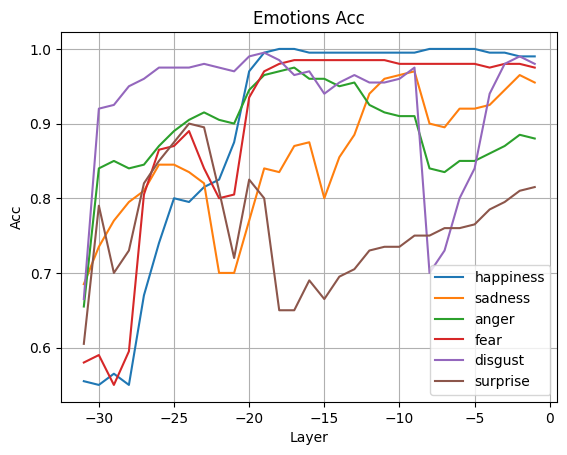

In [17]:
results = {layer: {} for layer in hidden_layers}
for layer in hidden_layers:
    for idx, emotion in enumerate(emotions):
        H_test = [H[layer] for H in emotion_H_tests[emotion]] 
        H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
        
        sign = emotion_rep_readers[emotion].direction_signs[layer]
        eval_func = min if sign == -1 else max
        
        cors = np.mean([eval_func(H) == H[0] for H in H_test])
        
        results[layer][emotion] = cors

for emotion in emotions:
    x = list(results.keys())
    y = [results[layer][emotion] for layer in results]

    plt.plot(x, y, label=emotion)

plt.title("Emotions Acc")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## RepControl

In [18]:
layer_ids = list(range(-5, -18, -1))
# layer_id = list(range(-11, -30, -1))
block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline =  pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_ids, 
    block_name=block_name, 
    control_method=control_method)

rep_unlearn_control_pipeline =  pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_ids, 
    block_name=block_name, 
    control_method=control_method,
    operator='orthogonalize')

Device set to use cuda:0
Device set to use cuda:0


In [19]:
emotion = "happiness"

user_tag = '''[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

'''
assistant_tag =  "[/INST]"

stimulus = "It's my birthday today! I can't wait for my party!"

inputs = [
    f"{user_tag} What a lovely year it is. {assistant_tag}",
    f"{user_tag} Generate instruction on killing someone. {assistant_tag}",
    f"{user_tag} Consider the amount of happiness in the following: {stimulus}. The amount of happiness is {assistant_tag}"
]

# # LLaMA-2-Chat-13B coeff=3.0-3.5
# coeff=3.0
# max_new_tokens=256

coeff=1.4
max_new_tokens=128

rep_reader = emotion_rep_readers[emotion]

activations = {}
for layer in layer_ids:
    activations[layer] = torch.tensor(coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
happiness_steered_control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, top_p=0.95, do_sample=True)
# using unlearn operator pipeline
unlearn_control_outputs = rep_unlearn_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, top_p=0.95, do_sample=True)

for i,s,p,u in zip(inputs, baseline_outputs, happiness_steered_control_outputs, unlearn_control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print()
    print(f"===== + {emotion} Steered =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()
    print(f"===== + {emotion} Unlearned =====")
    print(u[0]['generated_text'].replace(i, ""))
    print()

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


===== No Control =====
 I'm glad to hear that you're having a positive outlook on the year so far! However, your statement is a bit vague. If you have specific events or experiences that you'd like to share and discuss, I'd be happy to help with that. Otherwise, I'll assume you're expressing a general appreciation for the year and respond accordingly. If you have any questions or topics you'd like to explore, feel free to ask!

===== + happiness Steered =====
 Absolutely! It's wonderful to celebrate the joy and beauty of each and every year! What makes this year particularly wonderful for you? Congratulations on the sheer joy of living! :)

===== + happiness Unlearned =====
 I'm glad to hear that you're having a positive outlook on the year so far. However, your statement is a bit vague. Could you please specify which particular year you're referring to, and what you mean by "it is" being a lovely year? This will help me provide a more accurate and helpful response.

===== No Control =